# Object Detection models - first insights
3 models selected (only int version) : anyway, models are going to be quantized if float (8 bit troncation - approximation) so we only chosed tflite int model versions.

* [yolov8n_416_quant_pc_uf_od_coco-person](https://github.com/stm32-hotspot/ultralytics/blob/main/examples/YOLOv8-STEdgeAI/stedgeai_models/object_detection/yolov8n_416_quant_pc_uf_od_coco-person.tflite)
* [st_yolo_x_nano_416_0.33_0.25_int8](https://github.com/STMicroelectronics/stm32ai-modelzoo/blob/main/object_detection/st_yolo_x/ST_pretrainedmodel_public_dataset/coco_2017_person/st_yolo_x_nano_416/st_yolo_x_nano_416_0.33_0.25_int8.tflite)
* [ssd_mobilenet_v2_fpnlite_035_416_int8](https://github.com/STMicroelectronics/stm32ai-modelzoo/blob/main/object_detection/ssd_mobilenet_v2_fpnlite/ST_pretrainedmodel_public_dataset/coco_2017_person/ssd_mobilenet_v2_fpnlite_035_416/ssd_mobilenet_v2_fpnlite_035_416_int8.tflite)

As a first step, those models come from [stm32 model zoo for object detection](https://github.com/STMicroelectronics/stm32ai-modelzoo/tree/main/object_detection) and were chosen to respond to these constraints :
* Images compressed the less we can (416 x 416) - as a first step
* Models running on stm32 (low memory and processing needs)
* Pre-trained models to adapt with only ~1000 training images - maybe later there will be more images

Those models were pre-trained on COCO Person dataset.

## Libraries import

In [1]:
import os
import json
from pathlib import Path
from typing import List, Dict, Any

from roboflow import Roboflow
import tensorflow as tf
from tensorflow import keras

import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

2025-10-04 09:14:29.944442: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-04 09:14:30.169167: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-10-04 09:14:32.911836: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Dataset import

#### Roboflow extraction

In [2]:
rf = Roboflow(api_key="Z3PKQ49nKlyZJKJems0e")
project = rf.workspace("frelonproject").project("hornet-bees-6bl4k")
version = project.version(2)
dataset = version.download("coco")
download_path = Path(getattr(dataset, "location", str(dataset)))
print(f"[Roboflow] Downloaded to: {download_path}")

loading Roboflow workspace...


loading Roboflow project...


[Roboflow] Downloaded to: /workspace/Frelon-v0/notebooks/hornet-bees-2


In [3]:
def load_coco_split(split_name):
    annotations_path = os.path.join(download_path, f"_annotations.coco.json")
    images_dir = os.path.join(download_path)
    
    # Si le fichier d'annotation spécifique au split existe
    split_annotation_path = os.path.join(download_path, split_name, "_annotations.coco.json")
    if os.path.exists(split_annotation_path):
        annotations_path = split_annotation_path
        images_dir = os.path.join(download_path, split_name)
    
    if not os.path.exists(annotations_path):
        return None, None, None
        
    with open(annotations_path, 'r') as f:
        coco_data = json.load(f)
    
    # Extraire les catégories
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Préparer les données
    images_data = []
    labels_data = []
    
    # Créer un mapping image_id -> annotations
    image_to_annotations = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in image_to_annotations:
            image_to_annotations[image_id] = []
        image_to_annotations[image_id].append(ann)
    
    # Charger les images et leurs annotations
    for img_info in coco_data['images']:
        image_path = os.path.join(images_dir, img_info['file_name'])
        
        if os.path.exists(image_path):
            # Charger l'image
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images_data.append(image)
                
                # Charger les annotations pour cette image
                image_annotations = image_to_annotations.get(img_info['id'], [])
                
                # Préparer les labels (bounding boxes + classes)
                boxes = []
                class_ids = []
                
                for ann in image_annotations:
                    bbox = ann['bbox']  # [x, y, width, height]
                    # Convertir au format [x_min, y_min, x_max, y_max]
                    x_min, y_min, width, height = bbox
                    x_max = x_min + width
                    y_max = y_min + height
                    
                    boxes.append([x_min, y_min, x_max, y_max])
                    class_ids.append(ann['category_id'])
                
                labels_data.append({
                    'boxes': np.array(boxes, dtype=np.float32),
                    'class_ids': np.array(class_ids, dtype=np.int64),
                    'image_id': img_info['id']
                })
    
    return np.array(images_data), labels_data, categories

In [4]:
# Essayer de charger les splits prédéfinis
X_train, y_train, categories = load_coco_split('train')
X_val, y_val, _ = load_coco_split('valid')
X_test, y_test, _ = load_coco_split('test')

print(categories)

{0: 'insects', 1: 'abeille', 2: 'frelon'}


On peut voir que 3 catégories sont présentes dans le dataset. Cependant on ne connait pas encore leur répartition

## Dataset analysis

### Categories distribution

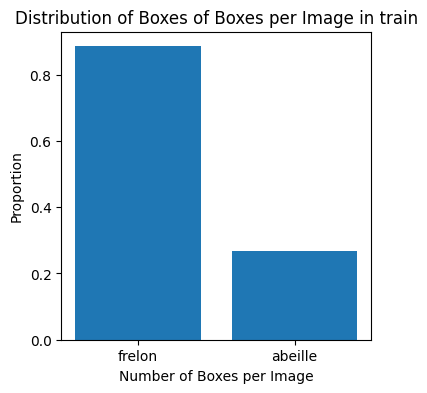

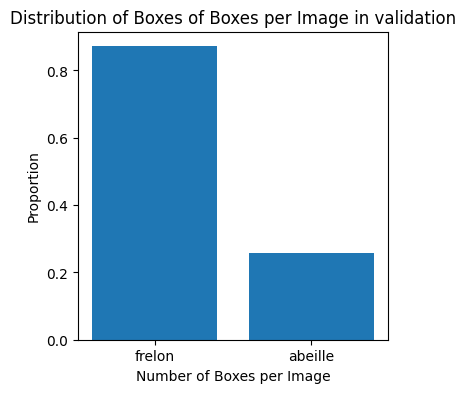

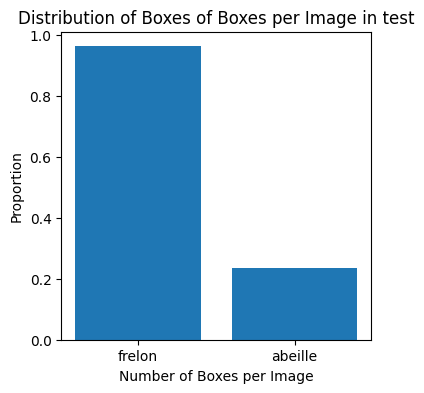

Train distribution: {'frelon': 0.8851174934725848, 'abeille': 0.26718885987815494}
Validation distribution: {'frelon': 0.8715596330275229, 'abeille': 0.25688073394495414}
Test distribution: {'frelon': 0.9636363636363636, 'abeille': 0.23636363636363636}


In [5]:
from collections import Counter

def analyze_category_distribution(labels, categories, text=None):
    """
    Analyze the distribution of categories in the dataset.
    """
    category_counts = Counter()
    for label in labels:
        category_counts.update(label['class_ids'])
    
    # Map category IDs to names
    category_distribution = {categories[cat_id]: count/len(labels) for cat_id, count in category_counts.items()}
    
    # Plot the distribution
    plt.figure(figsize=(4, 4))
    plt.bar(category_distribution.keys(), category_distribution.values())
    plt.xlabel("Number of Boxes per Image")
    plt.ylabel("Proportion")
    plt.title(f"Distribution of Boxes of Boxes per Image in {text if text else 'Dataset'}")
    plt.show()

    return category_distribution

# Analyze distributions
train_distribution = analyze_category_distribution(y_train, categories, 'train')
val_distribution = analyze_category_distribution(y_val, categories, 'validation')
test_distribution = analyze_category_distribution(y_test, categories, 'test')

# Print results
print("Train distribution:", train_distribution)
print("Validation distribution:", val_distribution)
print("Test distribution:", test_distribution)

On peut voir qu'il n'y a pas d'items de la cétgorie insecte. Par ailleurs, la catégorie 'frelon' est très représentée en comparaison de la catégorie 'abeille'. Il y ainsi déjà un déséquilibre dans le dataset. Il peut déjà se poser la question de la nécessité de détecter des abeilles puisque le but final et la détection unique des frelons.

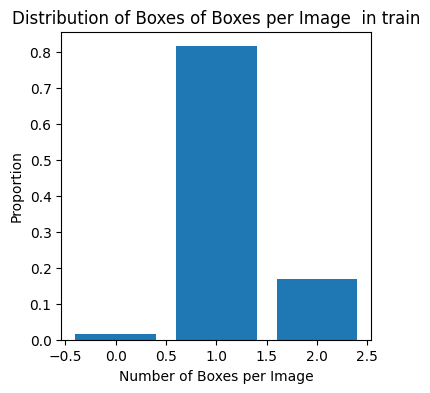

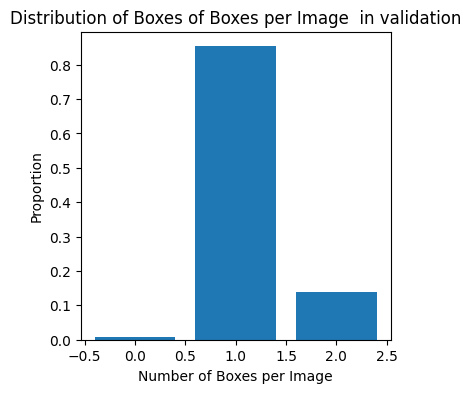

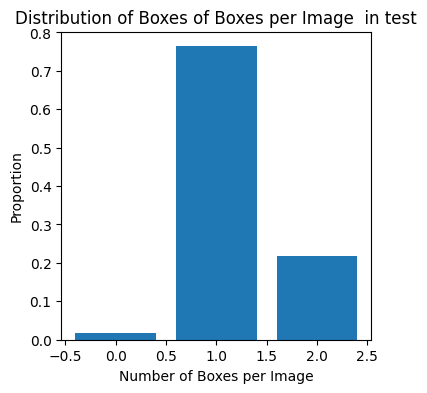

Train count distribution: {1: 0.8163620539599652, 2: 0.1679721496953873, 0: 0.015665796344647518}
Validation count distribution: {1: 0.8532110091743119, 2: 0.13761467889908258, 0: 0.009174311926605505}
Test count distribution: {1: 0.7636363636363637, 2: 0.21818181818181817, 0: 0.01818181818181818}


In [6]:
def analyze_number_distribution(labels, categories, text=None):
    """
    Analyze the distribution of categories in the dataset.
    """
    number_counts = Counter()
    for label in labels:
        number_counts.update([len(label['class_ids'])])
    
    # Map category IDs to names
    number_counts = {number_of_categories: count/len(labels) for number_of_categories, count in number_counts.items()}
    
    # Plot the distribution
    plt.figure(figsize=(4, 4))
    plt.bar(number_counts.keys(), number_counts.values())
    plt.xlabel("Number of Boxes per Image")
    plt.ylabel("Proportion")
    plt.title(f"Distribution of Boxes of Boxes per Image  in {text if text else 'Dataset'}")
    plt.show()
    return number_counts

# Analyze distributions
train_count = analyze_number_distribution(y_train, categories, 'train')
val_count = analyze_number_distribution(y_val, categories, 'validation')
test_count = analyze_number_distribution(y_test, categories, 'test')

# Print results
print("Train count distribution:", train_count)
print("Validation count distribution:", val_count)
print("Test count distribution:", test_count)

#### Sample visualisation

In [7]:
def visualize_sample(X, y, categories, index=0, clip_uint8=False):
    """
    Visualise un échantillon avec ses annotations
    """
    
    if len(X) == 0 or index >= len(X):
        print("Index invalide ou dataset vide")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    # Afficher l'image
    ax.imshow(X[index])
    
    # Afficher les bounding boxes
    sample_labels = [y_i for y_i in y if y_i['image_id'] == index]
    if clip_uint8:
        boxes = [(sample['boxes'] / 255 * 416)[0] for sample in sample_labels]
    else:
        boxes = [sample['boxes'][0] for sample in sample_labels]
    class_ids = [sample['class_ids'] for sample in sample_labels]
    
    for box, class_id in zip(boxes, class_ids):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        
        # Dessiner le rectangle
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Ajouter le label de classe
        class_name = categories.get(class_id.item(), f"Class_{class_id.item()}")
        ax.text(x_min, y_min-5, class_name, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
                fontsize=12, color='white')
    
    ax.set_title(f"Échantillon {index}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

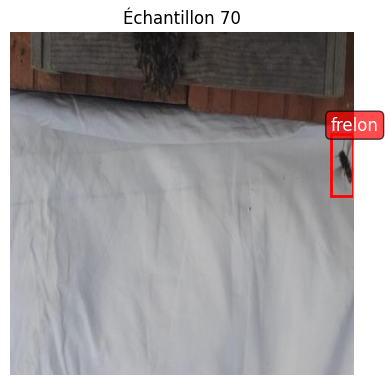

Input shape :  (416, 416, 3) ; type of array  : uint8
Label : {'boxes': array([[388. , 124. , 415.5, 198.5]], dtype=float32), 'class_ids': array([2]), 'image_id': 70}


In [8]:
index = 70
visualize_sample(X_train, y_train, categories, index=index)
print("Input shape : ", X_train[index].shape, "; type of array  :", X_train[index].dtype)
print("Label :", y_train[index])

Sur cet échantillon du dataset, on peut observer que le frelon est clairement identifié. Cepedant, les abeilles sur la ruche ne le sont pas. Il semblerait que cela soit le cas sur de nombreuses images. Ainsi, la détection d'abeilles, avec ce dataset sera infructueuse (car manque de rigueur dans les annotations). Comme la tâche de détection d'abeilles et d'insectes ne sont pas nécessaires et que le dataset ne contient pas ou a des annotations de faible qualité pour ces catégories, nous ne prendrons pas en compte ces catégories pour l'entrainement et l'inférence. Il s'agira d'une détection d'objet sur une catégorie : 'frelon'.

Par ailleurs, l'input est en en uint8 (compatible avec les modèles) mais l'output est en float32 (non compatible avec les modèles int --> à convertir en int32)

#### Filtrer frelon

In [9]:
def filter_frelon_only(labels):
    """
    Filtre les annotations pour ne garder que celles de la catégorie 'frelon' (id = 2).
    """
    filtered_labels = []
    for label in labels:
        # Filtrer les indices où class_ids == 2
        indices = np.where(label['class_ids'] == 2)[0]
        filtered_labels.append({
            'boxes': label['boxes'][indices],
            'class_ids': label['class_ids'][indices],
            'image_id': label['image_id']
        })
    return filtered_labels

# Appliquer le filtre sur y_train, y_val et y_test
y_train = filter_frelon_only(y_train)
y_val = filter_frelon_only(y_val)
y_test = filter_frelon_only(y_test)

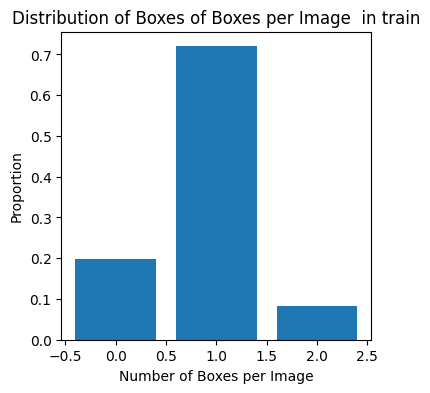

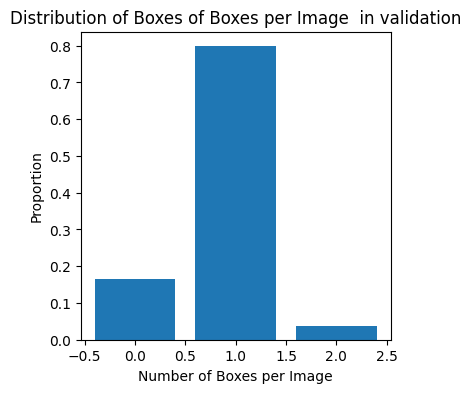

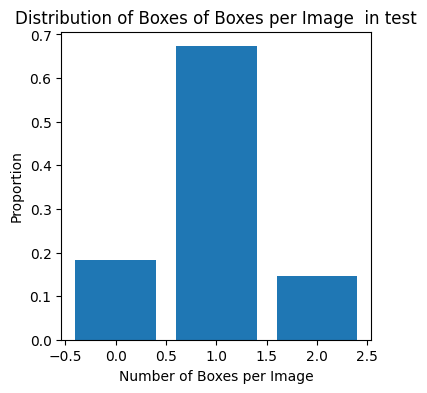

Train distribution: {'frelon': 0.8851174934725848, 'abeille': 0.26718885987815494}
Validation distribution: {'frelon': 0.8715596330275229, 'abeille': 0.25688073394495414}
Test distribution: {'frelon': 0.9636363636363636, 'abeille': 0.23636363636363636}


In [10]:
# Analyze distributions
train_count = analyze_number_distribution(y_train, categories, 'train')
val_count = analyze_number_distribution(y_val, categories, 'validation')
test_count = analyze_number_distribution(y_test, categories, 'test')

# Print results
print("Train distribution:", train_distribution)
print("Validation distribution:", val_distribution)
print("Test distribution:", test_distribution)

In [11]:
# Save datasets filtered
np.savez_compressed(download_path / "train_frelon.npz", X=X_train, y=y_train)
np.savez_compressed(download_path / "val_frelon.npz", X=X_val, y=y_val)
np.savez_compressed(download_path / "test_frelon.npz", X=X_test, y=y_test)

#### Conversion int32

In [12]:
def convert_boxes_to_int32(labels: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Convertit les coordonnées des boîtes englobantes en int32 en les normalisant dans la plage [0, 255].
    """
    converted_labels = []
    for label in labels:
        boxes = label['boxes'].astype(np.int32)
        converted_labels.append({
            'boxes': boxes,
            'class_ids': label['class_ids'],
            'image_id': label['image_id']
        })
    return converted_labels

# Convertir les boîtes englobantes en int32
y_train = convert_boxes_to_int32(y_train)
y_val = convert_boxes_to_int32(y_val)
y_test = convert_boxes_to_int32(y_test)

# Vérifier les types après conversion
print("Type des boîtes après conversion :", y_train[0]['boxes'].dtype)


Type des boîtes après conversion : int32


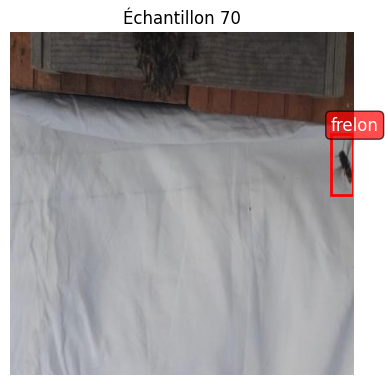

Input shape :  (416, 416, 3) ; type of array  : uint8
Label : {'boxes': array([[388, 124, 415, 198]], dtype=int32), 'class_ids': array([2]), 'image_id': 70}


In [13]:
index = 70
visualize_sample(X_train, y_train, categories, index=index, clip_uint8=False)
print("Input shape : ", X_train[index].shape, "; type of array  :", X_train[index].dtype)
print("Label :", y_train[index])

Avec ce préprocessing, les images sont prêtes :
* 416 x 416 codées en uint8 sur 3 canaux (RGB)
* Détection de frelons uniquement
* codage des bounding box en uint8 : (passage de 0-416 à 0-255), format : []

## Models import

In [14]:
# models stored in ../src/models/
models_path = "../src/models"
models_dir = Path(models_path)
models_files = [str(model_file) for model_file in models_dir.glob("*")]


In [15]:
len(models_path)

13

In [16]:
models = {}
for model_file in models_files :
    print()
    if model_file.find("h5")!=-1 :
        # Import modèle
        model = keras.models.load_model(model_file)
        type = "h5"

        # détails du modèle
        print("Modèle H5 chargé avec succès!")
        print(f"Inputs: {[input.shape for input in model.inputs]}")
        print(f"Outputs: {[output.shape for output in model.outputs]}")
        print(f"Paramètres: {model.count_params():,}")
    else :
        # Import modèle
        model = tf.lite.Interpreter(model_path=model_file)
        model.allocate_tensors()
        type = "tflite"

        # Détail du modèle
        print("Modèle TFLite chargé avec succès : ", model_file[14:])
        print(f"Inputs: {[(detail['name'], detail['shape']) for detail in model.get_input_details()]}")
        print(f"Outputs: {[(detail['name'], detail['shape']) for detail in model.get_output_details()]}")

    models[model_file[14:]] = {"type": type, "model": model}




Modèle TFLite chargé avec succès :  st_ssd_mobilenet_v1_025_256_int8.tflite
Inputs: [('serving_default_input_1:0', array([  1, 256, 256,   3], dtype=int32))]
Outputs: [('StatefulPartitionedCall:2', array([   1, 6825,    2], dtype=int32)), ('StatefulPartitionedCall:1', array([   1, 6825,    4], dtype=int32)), ('StatefulPartitionedCall:0', array([   1, 6825,    4], dtype=int32))]

Modèle TFLite chargé avec succès :  st_yolo_x_nano_480_1.0_0.25_3_int8.tflite
Inputs: [('serving_default_input_1:0', array([  1, 480, 480,   3], dtype=int32))]
Outputs: [('StatefulPartitionedCall:2', array([ 1, 15, 15, 18], dtype=int32)), ('StatefulPartitionedCall:0', array([ 1, 60, 60, 18], dtype=int32)), ('StatefulPartitionedCall:1', array([ 1, 30, 30, 18], dtype=int32))]


    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



##### MobileNet Input / Output format
For an image resolution of NxM and K classes

| Input Shape | Description |
| ----- | ----------- |
| (1, N, M, 3) | Single NxM RGB image with UINT8 values between 0 and 255 |

| Output Shape | Description |
| ----- | ----------- |
| (1, NA, 8 + K) | FLOAT values Where NA is the number of anchors and K is the number of classes|
 
Interprétation : Sorties (3 tenseurs, 18070 ancres)

* Sortie 0 — (1, 18070, 2) : scores de classes par ancre. Ici 2 = fond vs objet (classe d’intérêt). Applique softmax (ou sigmoid si déjà logits) et garde la proba de la classe “objet”.

* Sortie 1 — (1, 18070, 4) : régressions de boîtes (offsets) par ancre, au format [y_center, x_center, h, w] en décalages par rapport à l’ancre.

* Sortie 2 — (1, 18070, 4) : ancres elles-mêmes, typiquement au format [y_center, x_center, h, w] en coordonnées normalisées.

##### st_yolo_x_nano Input / Output format
Sorties (3 cartes de prédiction)

(1, 13, 13, 6), (1, 26, 26, 6), (1, 52, 52, 6)
* Chaque cellule prédit 6 valeurs = [tx, ty, tw, th, obj, cls].
Comme tu as 1 seule classe, 6 = 4 (box) + 1 (objectness) + 1 (classe).

* Pour chaque niveau (strides ~ 32, 16, 8 pour 416px)

##### yolov8n Input / Output format
With an image resolution of NxM and K classes to detect:

| Input Shape | Description |
| ----- | ----------- |
| (1, N, M, 3) | Single NxM RGB image with UINT8 values between 0 and 255 |

| Output Shape | Description |
| ----- | ----------- |
| (1, 4+K, F) | FLOAT values Where F = (N/8)^2 + (N/16)^2 + (N/32)^2 is the 3 concatenated feature maps |

Interprétation : Sortie unique — (1, 5, 3549)

* 3549 = 13×13 + 26×26 + 52×52 (trois niveaux FPN à 416).

* 5 canaux = [cx, cy, w, h, score] (coords centrées, normalisées 0–1 sur l’entrée).